In [22]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/sleep_health_clean.csv', sep=';')

X = data.drop(columns=["Sleep Disorder"], inplace=False)
y = data["Sleep Disorder"].values.reshape(-1, 1)

In [23]:
from sklearn.pipeline import Pipeline
import joblib

target_pipeline: Pipeline = joblib.load('data-pipelines-bin/target_pipeline')
predictor_pipeline: Pipeline = joblib.load('data-pipelines-bin/predictor_pipeline')

In [24]:
X = predictor_pipeline.transform(X)

In [25]:
y = target_pipeline.transform(y)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100, shuffle=True)

In [27]:
from keras_tuner import HyperParameters, GridSearch
from keras.models import Model
from keras.layers import Input,Dense
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.optimizers import Adam

In [28]:
def model_builder(hp: HyperParameters) -> Model:
    inputs = Input(shape=(21,), name='input', dtype=np.float32)
    units1 = hp.Int('units1', min_value=8, max_value=64, step=4)
    dense1 = Dense(units1,name='dense_1', activation='relu')(inputs)
    units2 = hp.Int('units2', min_value=4, max_value=32, step=2)
    dense2 = Dense(units2,name='dense_2', activation='relu')(dense1)
    output1 = Dense(3,name='output',activation='softmax')(dense2)
    model = Model(inputs = inputs, outputs = output1, name="sleep-health_classification")
    lr = hp.Float('learning_rate', min_value=1e-3,max_value=1e-2, step=1e-3)
    model.compile(loss=CategoricalCrossentropy(name='loss'),
                  optimizer=Adam(learning_rate=lr),
                  metrics=[CategoricalAccuracy(name='accuracy')]
                  )
    return model

In [29]:
early_stopping = EarlyStopping(monitor='loss',
                               min_delta=0.05,  # najmanja promena u odnosu na prethodnu epohu
                               patience=2,
                               # broj epoha sa promenom manjom od delta vrednosti nakon ceka trening staje
                               verbose=1,  # da prikaze zasto je trening zaustavljen
                               restore_best_weights=True)

In [30]:
tuner = GridSearch(model_builder,objective='loss', seed=100)

In [31]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# 
# 
# checkpoint = ModelCheckpoint(
#     weights_format,
#     monitor='loss',  # loss je parametar treniranja
#     verbose=0,  # 1 da prikazuje svaki callback, ne treba
#     save_best_only=True,  # svaka iteracija pamti samo najbolje tezine
#     mode='min'  # ako treba da se overwrituje fajl, zapamti sa manjim lossom
# )

In [32]:
tuner.search(X_train,y_train,epochs = 50, callbacks=[early_stopping])

Trial 2250 Complete [00h 00m 01s]
loss: 0.34729084372520447

Best loss So Far: 0.2818828523159027
Total elapsed time: 00h 43m 55s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [34]:
hypermodel: Model = tuner.hypermodel.build(best_hps)

In [35]:
history = hypermodel.fit(X_train, y_train, epochs=50, validation_split=0.2, shuffle = True,callbacks=[early_stopping], )


Epoch 1/50
8/8 [==============================] - 1s 20ms/step - loss: 0.7612 - accuracy: 0.7029 - val_loss: 0.5518 - val_accuracy: 0.8667
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4122 - accuracy: 0.8870 - val_loss: 0.5634 - val_accuracy: 0.9000
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3455 - accuracy: 0.9079 - val_loss: 0.5223 - val_accuracy: 0.9000
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3139 - accuracy: 0.9038 - val_loss: 0.5222 - val_accuracy: 0.9000
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.2893 - accuracy: 0.9079 - val_loss: 0.5610 - val_accuracy: 0.9000
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.2796 - accuracy: 0.9247 - val_loss: 0.5492 - val_accuracy: 0.9000
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.2744 - accuracy: 0.9289 - val_loss: 0.5566 - val_accuracy: 0.9000
Epoch 7: early stopping


In [36]:
eval = hypermodel.evaluate(x=X_test,y=y_test)

3/3 [==============================] - 0s 0s/step - loss: 0.4714 - accuracy: 0.9200


In [37]:
eval

[0.4714130759239197, 0.9200000166893005]

In [38]:
len(history.history['loss'])

7

In [39]:
history =  pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))

history.to_csv('results/history-tuned.csv', index=True, index_label = "Epoch")

In [40]:
pd.DataFrame(data={'Test Loss': eval[0], 'Test Accuracy': eval[1]}, index=[1]).to_csv('results/evaluation.csv', index=False)

In [43]:
hypermodel.save(filepath='results/model.keras', overwrite=True)

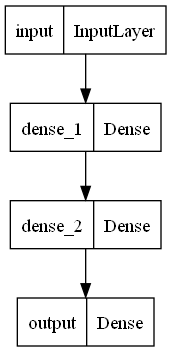

In [44]:
from keras.utils import plot_model

plot_model(hypermodel, to_file='model/model.png')